In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
from sklearn import cross_validation,preprocessing,tree

In [2]:
# Loading the data set
df = pd.read_csv("boston.csv")

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,BLACK,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Data set Description:
**Variable** | **__ Description__** |** Type**
---|---|---
CRIM|CRIM: per capita crime rate by town|Float
ZN|proportion of residential land zoned for lots over 25,000 sq.ft.|float
INDUS|proportion of non-retail business acres per town |float
CHAS|Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |Qualitative
NOX|nitric oxides concentration (parts per 10 million) |float
RM|Average number of rooms|float
AGE|proportion of owner-occupied units built prior to 1940 |float
DIS|weighted distances to five Boston employment centres|float
RAD|Index of accessibility to radial highways|Integer
TAX|full value property tax rate per 10,000 USD |Integer
PTRATIO|pupil-teacher ratio by town | float
B|B  1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |Float
LSTAT| Percent of lower status of the population |FLoat
MEDV|Median value of owner-occupied homes in $1000's|float


- Response Variable = Medv
- Problem Statement - Predict Median value of owner occupied home using Regression Tree




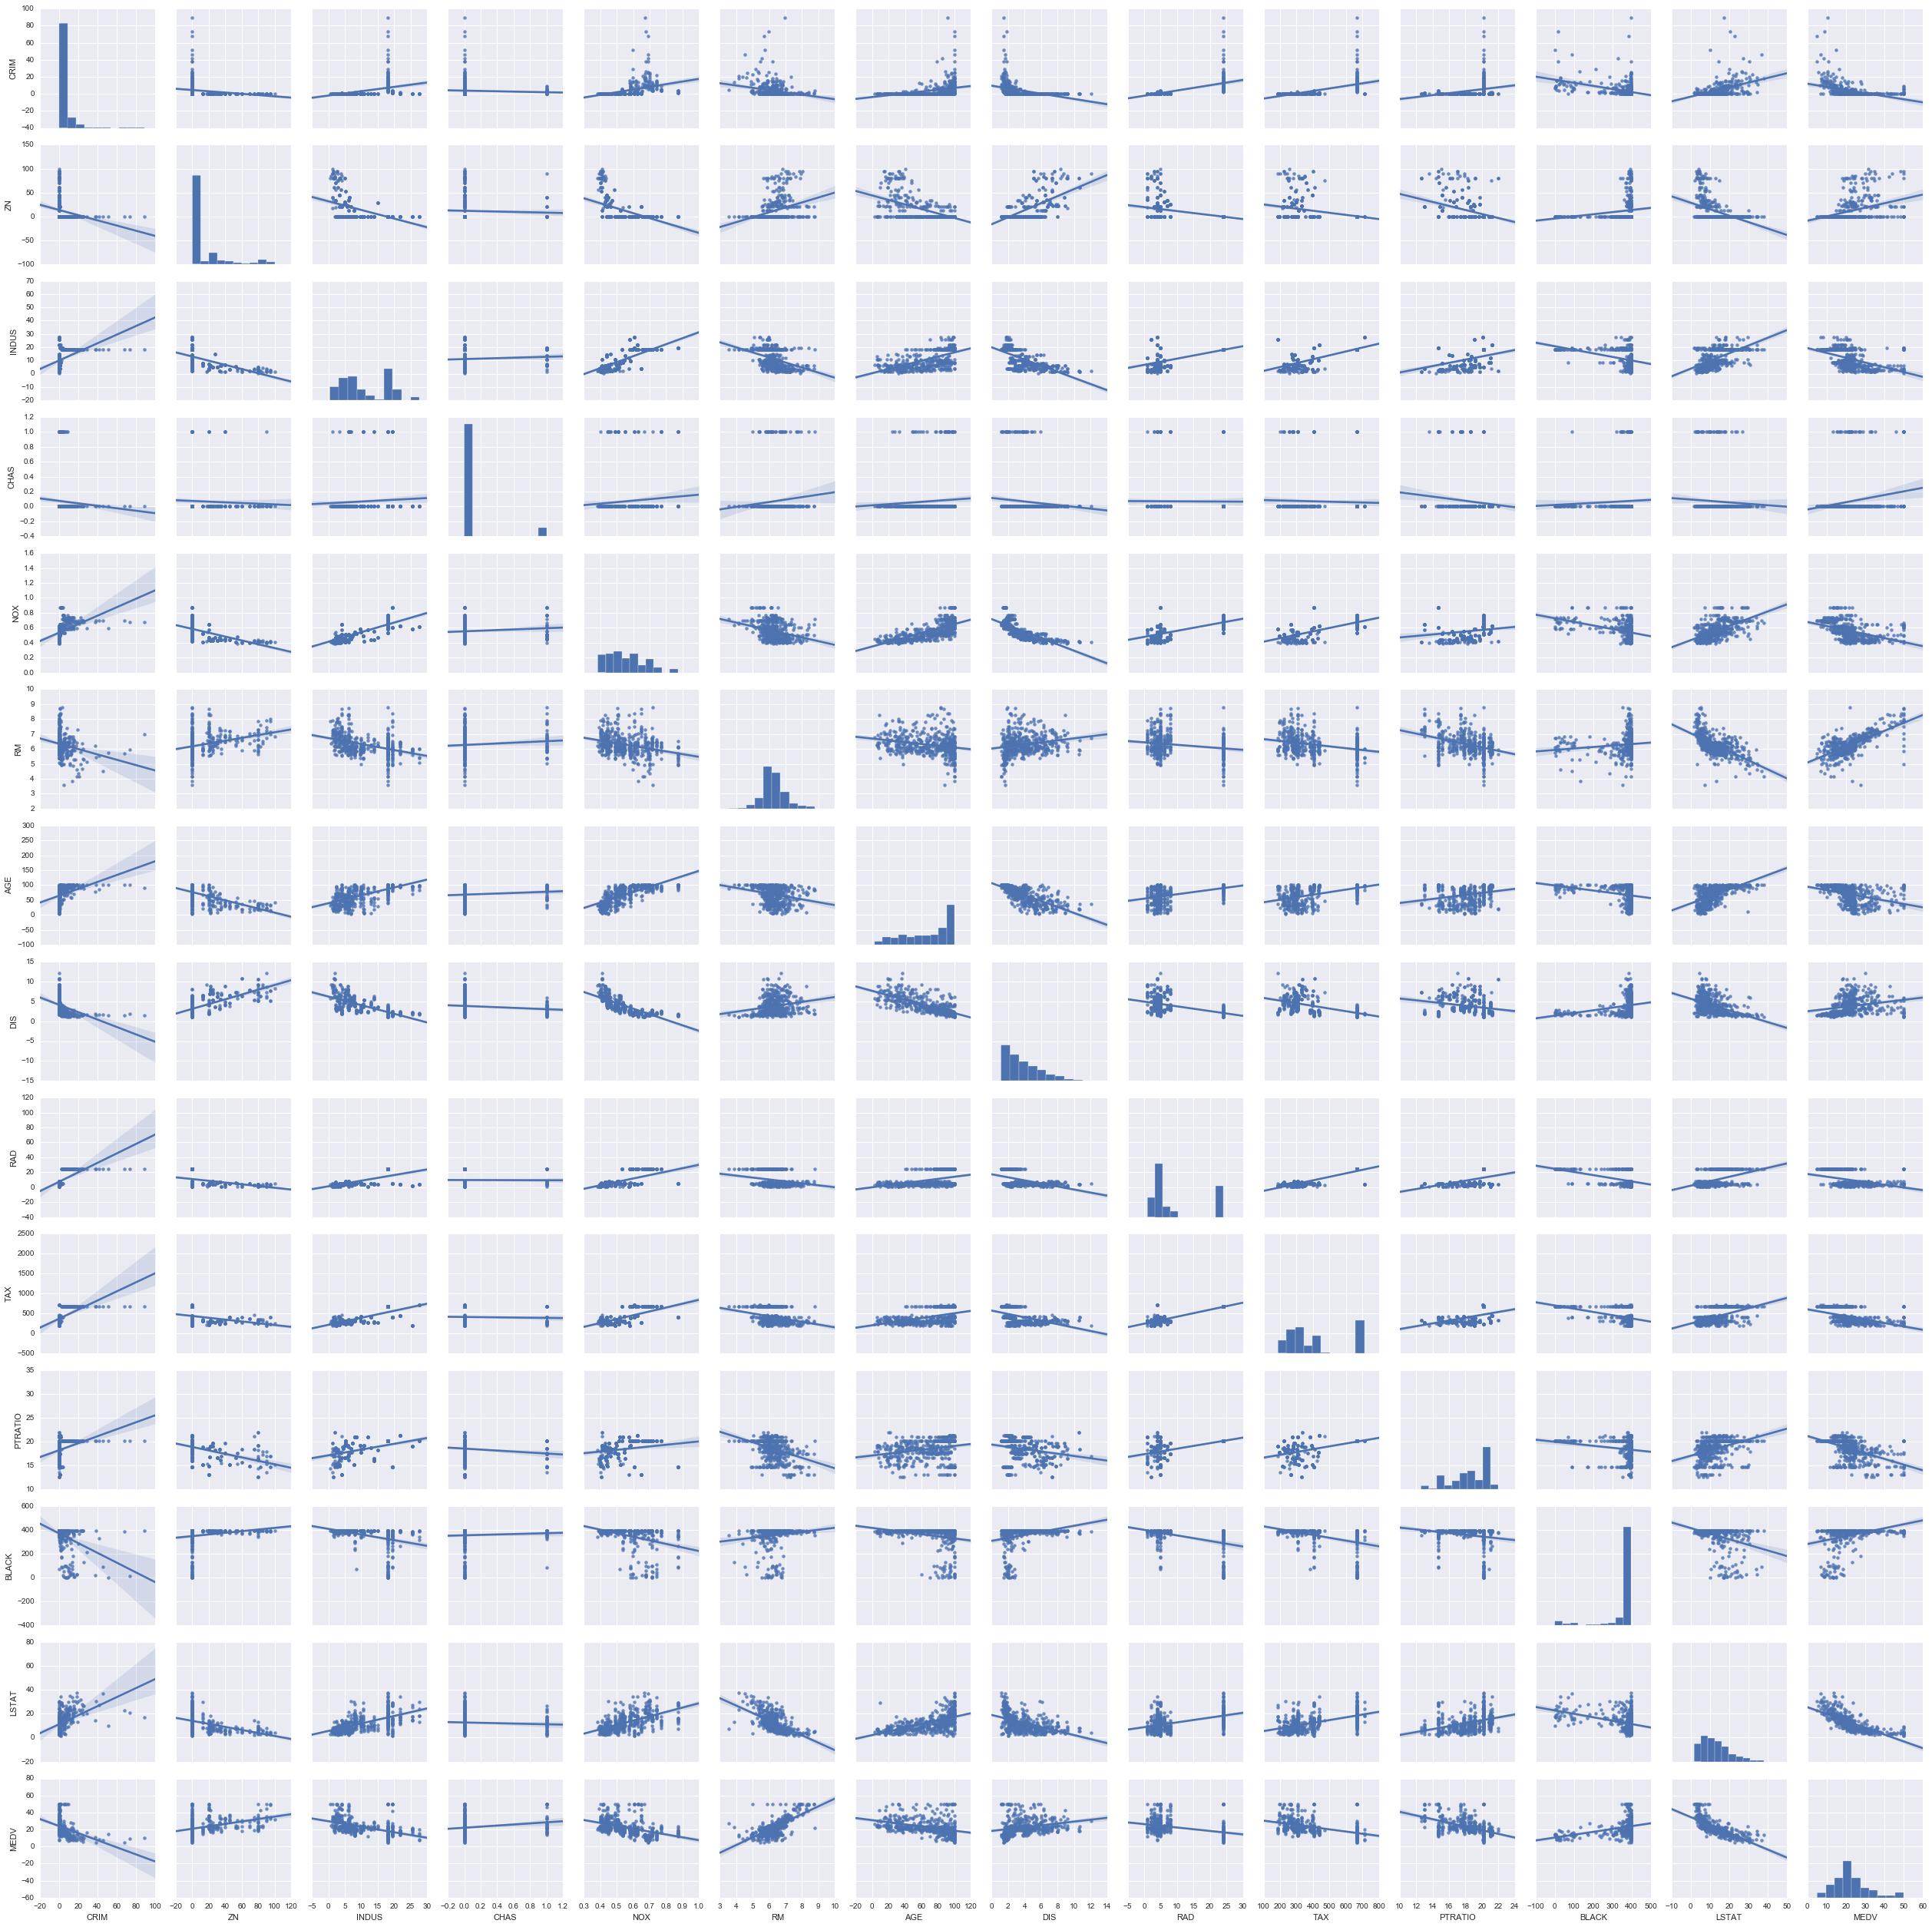

In [46]:
sns.pairplot(data=df,kind='reg')

In [6]:
#separating predictor and response variable
X = df.drop('MEDV',axis=1)
y = df.MEDV

# Train- Test split
train_X,test_X,train_y,test_y = cross_validation.train_test_split(X,y,test_size=.2)

In [11]:
#running a decision tree with default values
regressor = tree.DecisionTreeRegressor().fit(train_X,train_y)
regressor.score(train_X,train_y)

1.0

In [16]:
# Checking the features that are bein used for tree construction
sorted(zip(regressor.feature_importances_,X.columns),reverse=True)

[(0.56952175466723121, 'RM'),
 (0.18466043296218995, 'LSTAT'),
 (0.10389864536810375, 'DIS'),
 (0.037163550037139843, 'CRIM'),
 (0.02853491978186138, 'NOX'),
 (0.022139404015750225, 'TAX'),
 (0.01927117138697592, 'BLACK'),
 (0.018737586761805754, 'AGE'),
 (0.010295188623834925, 'PTRATIO'),
 (0.0044732368661671443, 'INDUS'),
 (0.0006661234485243918, 'CHAS'),
 (0.0004267715937100399, 'RAD'),
 (0.0002112144867056474, 'ZN')]

In [12]:
#running cross validation to estimate the test error
cross_validation.cross_val_score(regressor, train_X,train_y , cv= 10).mean()

0.75777966967791943

### Notes:
- decision tree regressor has perfectly fitted the training data, however cross vailidation suggests that the estimated test error would be ~75%, suggesting a possible overfit

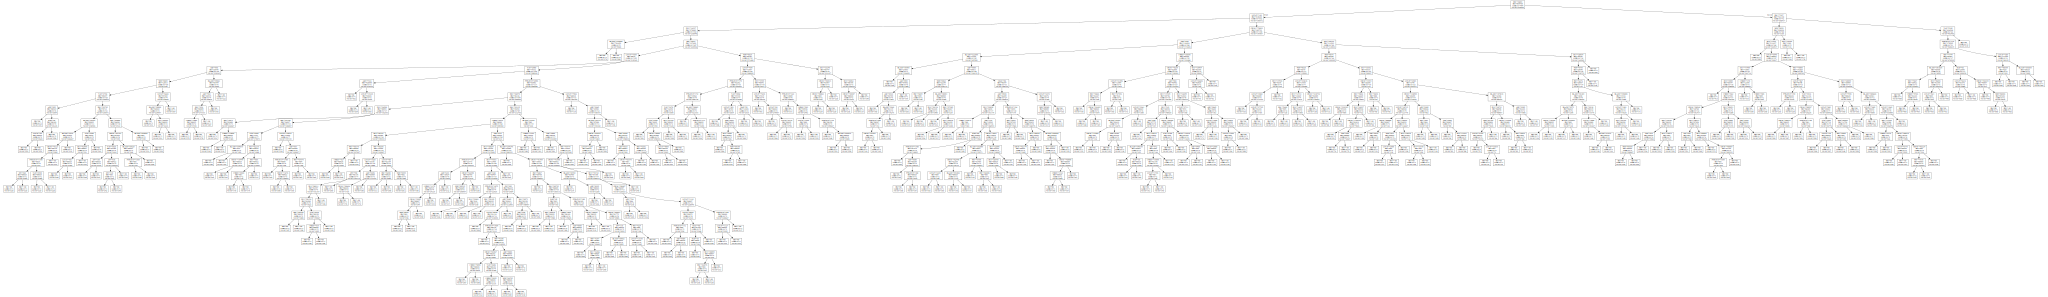

In [14]:
import pydotplus 
from sklearn import externals
from sklearn.externals.six import StringIO  
%reload_ext gvmagic
dot_data = externals.six.StringIO()
tree.export_graphviz(regressor, out_file = dot_data, feature_names = X.columns)
%dotstr dot_data.getvalue()

### *******Tuning the algorithm to reduce overfitting


In [28]:
depth = np.arange(1,20) # this will be used to create trees of different depth

# Split ratio will be used to dtermine the %of observations that are needed to be at aa leaf node

split_ratio = np.arange(10,100,11)*.01

In [26]:
depth

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [30]:
df_eval = pd.DataFrame({'train_score':np.nan,'cv_score':np.nan,'depth':np.nan,'leaf_sample':np.nan},index= [0])
for i in range(0,len(depth)):
    # empty lists to hold the values of scores in the inner loop
    best_depth = []
    best_split = []
    train_score = []
    cv_score = []
    for j in range(0,len(split_ratio)):
        model_temp = tree.DecisionTreeRegressor(max_depth = depth[i],min_samples_split=split_ratio[j])
        model_temp.fit(train_X,train_y)
        train_score.append(model_temp.score(train_X,train_y))
        cv_score.append(cross_validation.cross_val_score(model_temp,train_X,train_y,cv=10).mean())
    #selecting the maximum scores for inner loop
    df_eval.loc[i,'cv_score'] = max(cv_score) # selecting the max value for cv _score
    df_eval.loc[i,'train_score'] = max(train_score) # selecting the max value for train _score
    df_eval.loc[i,'depth'] = depth[i] # Selecting  the best depth
    df_eval.loc[i,'leaf_sample'] = cv_score.index(max(cv_score)) # selecting the index for the max cv_score
    
    
        
        
        

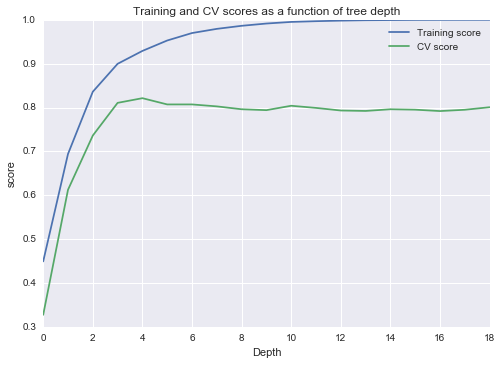

In [35]:
df_eval
plt.plot(df_eval.index ,df_eval.train_score,label='Training score' )
plt.plot(df_eval.index ,df_eval.cv_score,label='CV score' )
plt.legend(loc='best')
plt.xlabel('Depth')
plt.ylabel('score')
plt.title('Training and CV scores as a function of tree depth')

### Notes:
- It appears that the best cross validation score appears for a tree of depth 4, and it is also an improvement over the tree that was constructed with the default parameter that had a mean cv score of 75%


In [38]:
#selecting the best parameter for the model 
df_eval.ix[(df_eval.cv_score==df_eval.cv_score.max())]

,cv_score,depth,leaf_sample,train_score
4,0.82135,5.0,1.0,0.929137


In [50]:
# creating a tree with the best parameters:
regressor_final = tree.DecisionTreeRegressor(max_depth = 5 , min_samples_split = 1)
regressor_final.fit(X,y)
regressor_final.score(X,y)

0.91897315008405789

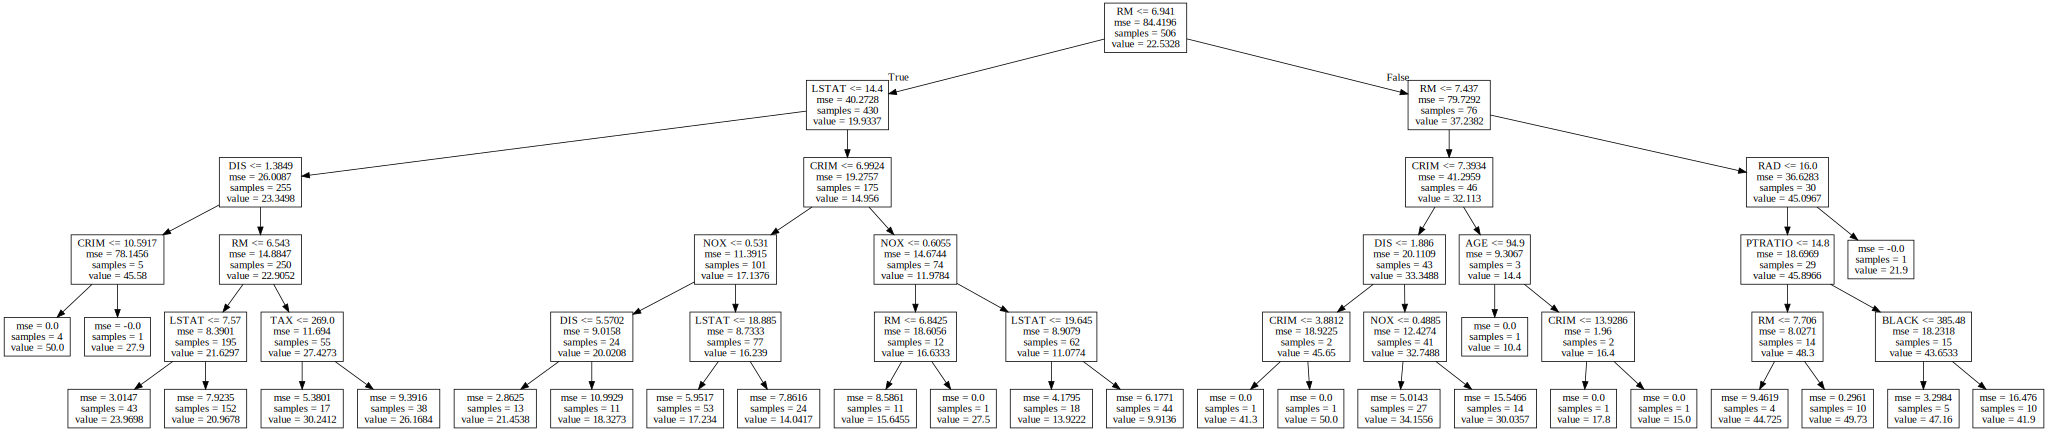

In [51]:
import pydotplus 
from sklearn import externals
from sklearn.externals.six import StringIO  
%reload_ext gvmagic
dot_data = externals.six.StringIO()
tree.export_graphviz(regressor_final, out_file = dot_data, feature_names = X.columns)
%dotstr dot_data.getvalue()

In [52]:
sorted(zip(regressor_final.feature_importances_,X.columns),reverse=True)

[(0.61247615196535332, 'RM'),
 (0.20347732317532854, 'LSTAT'),
 (0.073773079261535868, 'DIS'),
 (0.065627768692010369, 'CRIM'),
 (0.018558805878386448, 'NOX'),
 (0.014180058299373906, 'RAD'),
 (0.0049630663899136937, 'TAX'),
 (0.0039829782141769451, 'PTRATIO'),
 (0.0023493830417179477, 'BLACK'),
 (0.0006113850822029725, 'AGE'),
 (0.0, 'ZN'),
 (0.0, 'INDUS'),
 (0.0, 'CHAS')]

#### Conclusion:
- The best decision tree would be the one that would have a depth of 5 
- The r_squared of 82% implies that on an average 82% of the variation in the Median value of the house  would be explained by the other predictors